# Laboratoire 4 - Kinect

Au cours de ce laboratoire, nous allons étudier le capteur Kinect, qui permet 
d'obtenir des données de profondeur. Connectons-nous d'abord au robot.


In [1]:
import cv2

from robmob.rover.sensors import OakLiteCamera
%load_ext autoreload
%autoreload 2

import math

import matplotlib.pyplot as plt
import numpy as np

from robmob import robot
from robmob.point_cloud import PointCloud

robot_ip = 'localhost'  # Remplacez cette ip par l'ip de votre robot ou par localhost en simulation
robot = robot.Robot(robot_ip)
robot.connect()

error from callback <bound method Robot._on_error of <robmob.robot.Robot object at 0x735442385cc0>>: Échec de la connexion au robot


## Partie 1 - Visualisation

Ajoutons deux capteurs au robot, le capteur Kinect RGB qui retourne les images couleur et le capteur Kinect Depth qui retourne la coordonnée en `z` de chaque pixel.

> **NOTE** Le système de coordonnées utilisé est $z$ devant, $x$ à droite et $y$ vers le bas

In [2]:
camera = OakLiteCamera()
robot.add_sensor(camera)

[18443010115F5A1200] [1.5] [0.951] [ColorCamera(0)] [warning] Unsupported resolution set for detected camera IMX378/214, needs 1080_P / 4_K / 12_MP. Defaulting to 1080_P
Focal length: 3030.1787109375


AttributeError: 'OakLiteCamera' object has no attribute 'subscription_message'

La fonction suivante affiche les données retournées par la Kinect. Dans l'image du haut, la valeur du pixel est directement la distance en mètres. Vous pouvez afficher cette distance en mettant la souris sur le pixel.

In [34]:
def show_depth_data(depth_data, rgb_data=None):
    if rgb_data is not None:
        fig, (ax1, ax2) = plt.subplots(2, 1)
        im1 = ax1.imshow(depth_data, aspect='equal')
        im2 = ax2.imshow(rgb_data, aspect='equal')

        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im1, cax=cbar_ax)

        plt.show()
    else:
        plt.imshow(depth_data, aspect='equal')
        plt.colorbar()
        plt.show()

Appelons cette fonction avec les dernières données du capteur:

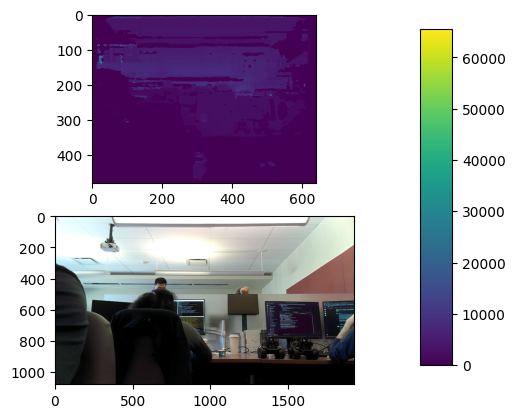

In [35]:
depth_data = camera.peek_depth()
rgb_data = camera.peek_rgb()

show_depth_data(depth_data, rgb_data)

> **NOTE** N'oubliez pas de fermer le graphique interactif avec le bouton bleu.

## Partie 2 - Conversion en nuage de points

Dans cette partie, nous allons convertir des données de profondeur en $z$ en un nuage de points $x$ $y$ $z$.


Nous avons déjà toutes les informations nécessaires. Le field-of-view de la Kinect se trouve dans les constantes ```KinectDepthSensor.FOV_X``` et  ```KinectDepthSensor.FOV_Y```. De même, le point principal se se trouve dans les constantes ```KinectDepthSensor.CENTER_X``` et  ```KinectDepthSensor.CENTER_Y```. Ces informations nous permettent déjà de trouver les angles en $x$ et $y$ de chaque pixel par rapport à l'axe optique.


La distance $z$ est connue, c'est ce qui est retourné directement par la Kinect. À partir des valeurs de `theta` et de $z$, on peut trouver les distances $dx$ et $dy$ qui représentent la composantes $x$ et $y$ du vecteur qui part de la caméra vers le point représenté à un pixel donné. Puis, avec ces distances, on peut trouver $x$ et $y$.

> **NOTE** Avec numpy, si on a une matrice **a** de taille 3x3 et un vecteur ligne **b** de taille 1x3, `a * b` représente le fait de multiplier le vecteur `b` element-wise sur chaque ligne. On parle ici de broadcasting en vocabulaire numpy. Cela évite les boucles for, qui sont plus lente que des opérations numpy.  

In [36]:
def to_points(depth_image, color_image=None, keep_invalid_points=False):
    height, width = depth_image.shape

    # Angle en x et y de chaque pixel par rapport à l'axe optique
    theta_x = np.arctan((np.arange(width) - OakLiteCamera.CENTER_X) / OakLiteCamera.FOCAL_LENGTH)
    theta_y = np.arctan((np.arange(height) - OakLiteCamera.CENTER_Y) / OakLiteCamera.FOCAL_LENGTH)
    theta_x = np.expand_dims(theta_x, axis=0)  # Vecteur ligne pour que le broadcasting fonctionne sur deepth_image
    theta_y = np.expand_dims(theta_y, axis=1)  # Vecteur colonne pour que le broadcasting fonctionne sur deepth_image

    # Calculer la position de chaque point
    x = np.tan(theta_x) * depth_image / OakLiteCamera.FOCAL_LENGTH
    y = np.tan(theta_y) * depth_image / OakLiteCamera.FOCAL_LENGTH
    z = depth_image

    # Met les matrices en colonne pour pouvoir les empiler
    x_column = np.reshape(x, (-1, 1))
    y_column = np.reshape(y, (-1, 1))
    z_column = np.reshape(z, (-1, 1))

    points = np.hstack((x_column, y_column, z_column))

    points_to_keep_mask = np.ones(points.shape[0], dtype=np.bool)
    if not keep_invalid_points:
        #Removes rows where the z value is 0, meaning unknown distance
        points_to_keep_mask = ~(abs(points) < 1e-6)[:, 2]

    # TODO ne conserver que les points où points_to_keep_mask est vrai
    points = points[points_to_keep_mask]
    
    if color_image is not None:
        # downsampling the color image to the same size as the depth image
        color_image = cv2.resize(color_image, (width, height), interpolation=cv2.INTER_AREA)
        colors = np.asarray(color_image).reshape((-1, 3))
        colors = colors[points_to_keep_mask]
        return points, colors
    else:
        return points

Appelez la fonction que vous venez de définir avec une depth image et l'image rgb correspondante. Les array numpy retournées ont un point par ligne, respectivement x, y, z et r, g, b. 

In [37]:
points, colors = to_points(depth_data, rgb_data)
print(points.shape, colors.shape)

TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

Pour visualizer le nuage de points en 3D, il suffit de créer un objet PointCloud et d'appeler la fonction save(). Cela va enregistrer sur le disque le nuage de points en format binaire pour un visualisateur web.

> **Attention!** La fonction save() écrase le nuage de points précédemment sauvegardé

Une fois la fonction save appelée, il suffit de cliquer sur le lien suivant pour ouvrir le visualisateur.

### [POINT CLOUD VIEWER](point_cloud/viewer.html)

> **NOTE** Si vous sauvegardez un nouveau nuage de points, il suffit de rafraîchir la page du visualisateur pour l'afficher.

Vous devrez peut-être exécuter le viewer avec:

```bash
cd point_cloud/
python3 -m http.server
# Ouvrir http://127.0.0.1:8000/ dans un navigateur internet (ou http://0.0.0.0:8000/)
# Cliquer sur viewer.html
```

In [31]:
PointCloud(points, colors).save()

## Partie 3 - Bruit de capteur
### Selon z (profondeur)
Les données obtenues avec la Kinect, comme avec tous autres capteurs, sont bruitées. De plus, les
profondeurs seront quantifiées (ne prendront pas des valeurs continues mais vont varier par des sauts
fixes), avec un pas variant avec la profondeur. Afin de mieux voir ces effets, placez la Kinect sur une
boite à environ un mètre du mur tel qu’illustré ci-dessous. Assurez-vous, autant que possible, que le
montage soit parallèle au mur.

**En simulation:** Placez-vous en face d'un des murs.

![Montage d'obsevation du bruit](./img/kinect-noise.png)

Le code suivant affiche la valeur de $z$ au centre de l'image et sur les côtés. 

In [20]:
depth_data = camera.peek_depth()

y = math.floor(depth_data.shape[0] / 2)
x_center = math.floor(depth_data.shape[1] / 2)
x_left = math.floor(depth_data.shape[1] / 5)
x_right = depth_data.shape[1] - x_left

z_center = depth_data[y, x_center]
z_left = depth_data[y, x_left]
z_right = depth_data[y, x_right]

print("Valeurs de z:")
print("Gauche: %1.8f m | Centre: %1.8f m | Droite: %1.8f m" % (z_left, z_center, z_right))

Valeurs de z:
Gauche: 0.00000000 m | Centre: 2535.00000000 m | Droite: 0.00000000 m


Répétez la démarche avec la Kinect à 3 mètres du mur, puis à 5 mètres. Est-ce que la précision sur les
mesures/grandeurs des pas est la même pour de plus grandes distances? D’après vos observations, est-
ce que la taille des sauts est 
- a) fixe?
- b) croit linéairement avec $z$?
- c) croit en $z^2$ ?

### Selon x
Le bruit dans une image produite
par une caméra se présente sous
plusieurs formes (e.g. distorsion
radiale). Étant donné que le calcul
de la position en x et en y pour
chaque pixel dépend de la valeur
bruitée en z et de la position du
pixel dans l’image (elle aussi
bruitée), il serait intéressant
d’observer la précision des valeurs
obtenues dans le nuage de point.


La fonction suivant prend en argument un nuage de points une coordonnée en pixel $i$ (ligne) $j$ (colonne) et retourne la coordonnée $xyz$ correspondante. Vous pouvez trouver les valeurs de $i$ et $j$ grâce à la visualisation plus haut.

In [21]:
def point_at(points, i, j):
    return points[i * 640 + j]

Placez le coté d’une boite au centre
optique horizontal de la caméra et
utilisez des règles (voir la figure ci-
dessous) pour mesurer la position
relative réelle d’un repère (e.g. le
coin inférieur droit de la boite).

![Montage d'obsevation du bruit 2](./img/kinect-noise-2.png)

**En simulation:** Utilisez un des piliers.

En utilisant les fonctions ```point_at``` et ```to_points```, vérifier si la position mesurée selon x correspond à la valeur dans le nuage de
point. Observez quelques mesures à cette position et répétez le processus pour une plus grande distance
en x et en z. Est-ce que la précision est similaire dans les deux cas ?

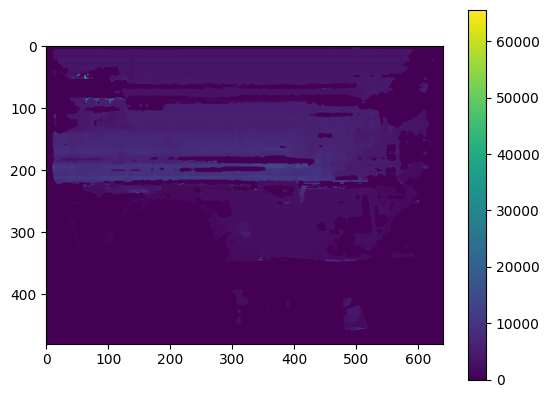

In [22]:
depth_data = (camera.peek_depth())
show_depth_data(depth_data)

In [23]:
i, j = 77, 424  #TODO
points = to_points(depth_data, keep_invalid_points=True)  # keep_invalid_points is used keep 640x480 points
# and be able index the points in i, j

print("x, y, z: " + str(point_at(points, i, j)))

x, y, z: [-1.88759205e-01 -1.63473579e-01  3.26700000e+03]


## Partie 4 - Détection de plans avec RANSAC
L’extraction de surfaces planes dans des nuages de points est une tâche clef dans le traitement et
l’analyse de ces derniers. Dans un environnement intérieur, ces surfaces planes correspondront à des
murs, au plancher, et à toutes autres surfaces planes présentes dans le champ visuel de la Kinect.
Comme plusieurs équipes utiliseront la Kinect pour naviguer, une des premières tâches consiste à
identifier le plancher dans un nuage de point. Cette méthode vous sera donc très utile pour vos projets!


Dans la première moitié du cours, nous avons vu l’algorithme RANSAC. L’extraction de surface plane
est une application intéressante de RANSAC, car vous cherchez une hypothèse (un plan en 3D) dans un
ensemble de donné bruités. La méthode consiste à piger, au hasard, 3 points dans le nuage. Ces trois
points définissent, de façon unique, un plan en 3D. S’il y a peu d’inliers à ce plan, cette hypothèse n’est
donc pas valide. Si, par contre, beaucoup de points sont des inliers, alors il y a de fortes chances qu’ils
constituent un plan.


Pour comprendre la fonction suivante, veillez vous référez à [ce site](http://mathworld.wolfram.com/Point-PlaneDistance.html) qui décrit comment trouver la distance entre un plan et un point. Prenez également note qu' il est possible de calculer la distance de tous les points tout en même temps. En effet, dans le lien, on fait le produit scalaire en deux vecteur pour avoir la distance. Cette opération peut également se représenter comme un produit matriciel dans le cas de plusieurs points (la fonction ```numpy.dot```). 


Le code suivant retourne un masque de booléens représentant les points qui font partie du plan principal. Il est possible par la suite de retrouver ces points avec l'opérateur crochet 
```
points[mask]
```

In [24]:
def find_plane_ransac(points, n_trials=1000, epsilon=1e-2):
    best_inliers, best_n_inliers = None, 0
    for _ in range(n_trials):
        #Select three points - the minimum number of points that define a plane
        plane_points = points[np.random.choice(points.shape[0], 3, replace=False)]

        #Define the plane by a unit vector
        # TODO trouver le vecteur normal au plan defini par les trois points
        normal_vector = np.cross(TODO, TODO)
        normal_unit_vector =  # TODO normaliser le vecteur normal

        #Compute distances between the points and the plane
        distances =  # TODO - distances should be an array of (n_points, 1)

        #Find inliers
        inliers = abs(distances) < epsilon
        n_inliers = np.count_nonzero(inliers)

        if n_inliers > best_n_inliers:
            best_inliers, best_n_inliers = inliers, n_inliers

    return best_inliers, best_n_inliers

SyntaxError: invalid syntax (1785765196.py, line 10)

### Extraction du plan principal

Premièrement, allons chercher des données de la Kinect:

In [ ]:
depth_data = depth_sensor.peek_data()
rgb_data = rgb_sensor.peek_data()
points, colors = to_points(depth_data, rgb_data)

show_kinect_data(depth_data, rgb_data)

Le défi est de trouver une bonne valeur de epsilon qui n'est ni trop permissive ni trop restrictive. Modifier la valeur d'epsilon dans le code suivant jusqu'à ce que vous soyez satisfaits du résultats dans le visualisateur de nuages de points.

In [ ]:
inliers, n_inliers = find_plane_ransac(points, 100, epsilon=2e-1)  #TODO change epsilon (in meters)
print("Found %d inliers" % n_inliers)

points_of_plane = points[inliers]
#Choose red color for the points of the principal plane
points_of_plane_colors = np.tile(np.array([255, 0, 0], dtype=np.uint8), (n_inliers, 1))

other_points = points[~inliers]  # ~inliers is the opposite boolean mask
other_points_colors = colors[~inliers]

# put all points in the same array
all_points = np.vstack((points_of_plane, other_points))
all_colors = np.vstack((points_of_plane_colors, other_points_colors))

In [ ]:
PointCloud(all_points, all_colors).save()

# Extraction de $n$ plans

Le code suivant extrait $n$ plans du nuage de points sans remise et les colore d'une couleur aléatoire.

In [ ]:
def color_n_planes(points, n, ransac_params={}):
    colored_points, colors = None, None
    remaining_points = points

    for i in range(n):
        inliers, n_inliers = find_plane_ransac(remaining_points, **ransac_params)
        points_of_plane = remaining_points[inliers]
        remaining_points = remaining_points[~inliers]

        random_color = np.random.randint(100, 200, size=[3], dtype=np.uint8)
        new_colors = np.tile(random_color, (n_inliers, 1))

        if colored_points is not None:
            colored_points = np.vstack((colored_points, points_of_plane))
            colors = np.vstack((colors, new_colors))
        else:
            colored_points = points_of_plane
            colors = new_colors

        if remaining_points.shape[0] < 3:
            break

    return colored_points, colors

Modifiez les valeurs de $epsilon$ et $n\_trials$ et observez le résultat

In [ ]:
depth_data = depth_sensor.peek_data()
rgb_data = rgb_sensor.peek_data()
points, colors = to_points(depth_data, rgb_data)

show_kinect_data(depth_data, rgb_data)

In [ ]:
pc, cc = color_n_planes(points, 4, ransac_params={'n_trials': 50, 'epsilon': 2e-2})

In [ ]:
PointCloud(pc, cc).save()